In [1]:
import sys
sys.path.insert(0, '..')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import random
from pathlib import Path

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import logging

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load Data

In [2]:
def print_stats(df):
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

    print(80*'-')
    for level in levels:
        print(level, len(df[level].unique()))

    print('Total sequences', df.shape[0])

def load_data(emb_file, csv_file) -> tuple[np.ndarray, pd.DataFrame]:
    """
    Load embeddings and CSV data files.

    Returns:
        tuple: A tuple containing embeddings (numpy array) and DataFrame (pandas).
    """
    try:
        # Check if files exist
        if not emb_file.is_file():
            raise FileNotFoundError(f"Embedding file not found: {emb_file}")
        if not csv_file.is_file():
            raise FileNotFoundError(f"CSV file not found: {csv_file}")
        
        logging.info(f"Loading embeddings from {emb_file}")
        embeddings = np.load(emb_file)
        
        logging.info(f"Loading DataFrame from {csv_file}")
        df = pd.read_csv(csv_file, sep='\t', index_col=0)
        
        return embeddings, df

    except Exception as e:
        logging.error(f"Error while loading data: {e}")
        raise

In [3]:
CSV_FILE = Path('../data/gg2.2024.09.backbone.full-length.csv.gz')
EMB_FILE  = Path('../data/embeddings/gg2.2024.09.backbone.full-length.DNABERT2.npy')


embeddings, df = load_data(emb_file=EMB_FILE, csv_file=CSV_FILE)

print(embeddings.shape)
print(df.shape)

df.reset_index(inplace=True)

print_stats(df)

(321398, 768)
(321398, 12)
--------------------------------------------------------------------------------
Phylum 131
Class 327
Order 918
Family 1986
Genus 7584
Species 21192
Total sequences 321398


---

In [4]:
def compute_intra_level_similarities(df: pd.DataFrame= None, embeddings: np.ndarray = None, num_per_level: int = 1_000):
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    res_dict = {level: [] for level in levels}

    for level in levels:
        print(' ->', level)
        while len(res_dict[level]) < num_per_level:
            id1 = random.choice(df.index.values)
            level_name = df.iloc[id1][level]
            if len(level_name) > 3: 
                arr = df[df[level] == level_name].index.values
                if len(arr) > 1:
                    id2 = random.choice(np.delete(arr, np.where(arr == id1)[0]))
                    sim = cosine_similarity(embeddings[id1].reshape(1, -1), embeddings[id2].reshape(1, -1))[0][0]
                    res_dict[level].append((sim, id1, id2))

    return res_dict

In [6]:
random.seed(10)
embeddings = np.load(Path('../data/embeddings/gg2.2024.09.backbone.full-length.DNABERTS.npy'))
res_dict_dnaberts = compute_intra_level_similarities(df=df, embeddings=embeddings, num_per_level=1_000)

 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species


In [7]:
random.seed(10)
embeddings = np.load(Path('../data/embeddings/gg2.2024.09.backbone.full-length.DNABERT2.npy'))
res_dict_dnabert2 = compute_intra_level_similarities(df=df, embeddings=embeddings, num_per_level=1_000)

 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species


In [8]:
random.seed(10)
embeddings = np.load(Path('../data/embeddings/gg2.2024.09.backbone.full-length.NT2-500.npy'))
res_dict_nt2 = compute_intra_level_similarities(df=df, embeddings=embeddings, num_per_level=1_000)

 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species


In [9]:
random.seed(10)
embeddings = np.load(Path('../data/embeddings/gg2.2024.09.backbone.full-length.Evo131K.npy'))
res_dict_evo = compute_intra_level_similarities(df=df, embeddings=embeddings, num_per_level=1_000)

 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species


In [10]:
# Convert dictionaries into long-form DataFrames
df1 = pd.DataFrame([
    {'Cosine Similarity': val[0], 'Level': key}
    for key, values in res_dict_dnaberts.items()
    for val in values
])

df2 = pd.DataFrame([
    {'Cosine Similarity': val[0], 'Level': key}
    for key, values in res_dict_dnabert2.items()
    for val in values
])

df3 = pd.DataFrame([
    {'Cosine Similarity': val[0], 'Level': key}
    for key, values in res_dict_nt2.items()
    for val in values
])

df4 = pd.DataFrame([
    {'Cosine Similarity': val[0], 'Level': key}
    for key, values in res_dict_evo.items()
    for val in values
])

In [11]:
# Define file paths and result keys
embedding_files = {
    "DNABERT-2": "gg2.2024.09.backbone.full-length.DNABERT2.npy",
    "DNABERT-S": "gg2.2024.09.backbone.full-length.DNABERTS.npy",
    "NT2-500": "gg2.2024.09.backbone.full-length.NT2-500.npy",
    "Evo131K": "gg2.2024.09.backbone.full-length.Evo131K.npy",
}

# Set base path and initialize result containers
base_path = Path("../data/embeddings")
results = {}
dfs = {}

# Compute similarities and build DataFrames
for model_name, filename in embedding_files.items():
    print('\n' + model_name)
    random.seed(10)
    embeddings = np.load(base_path / filename)
    res_dict = compute_intra_level_similarities(df=df, embeddings=embeddings, num_per_level=1_000)
    results[model_name] = res_dict

    dfs[model_name] = pd.DataFrame([
        {'Cosine Similarity': val[0], 'Level': key}
        for key, values in res_dict.items()
        for val in values
    ])


DNABERT-2
 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species

DNABERT-S
 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species

NT2-500
 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species

Evo131K
 -> Phylum
 -> Class
 -> Order
 -> Family
 -> Genus
 -> Species


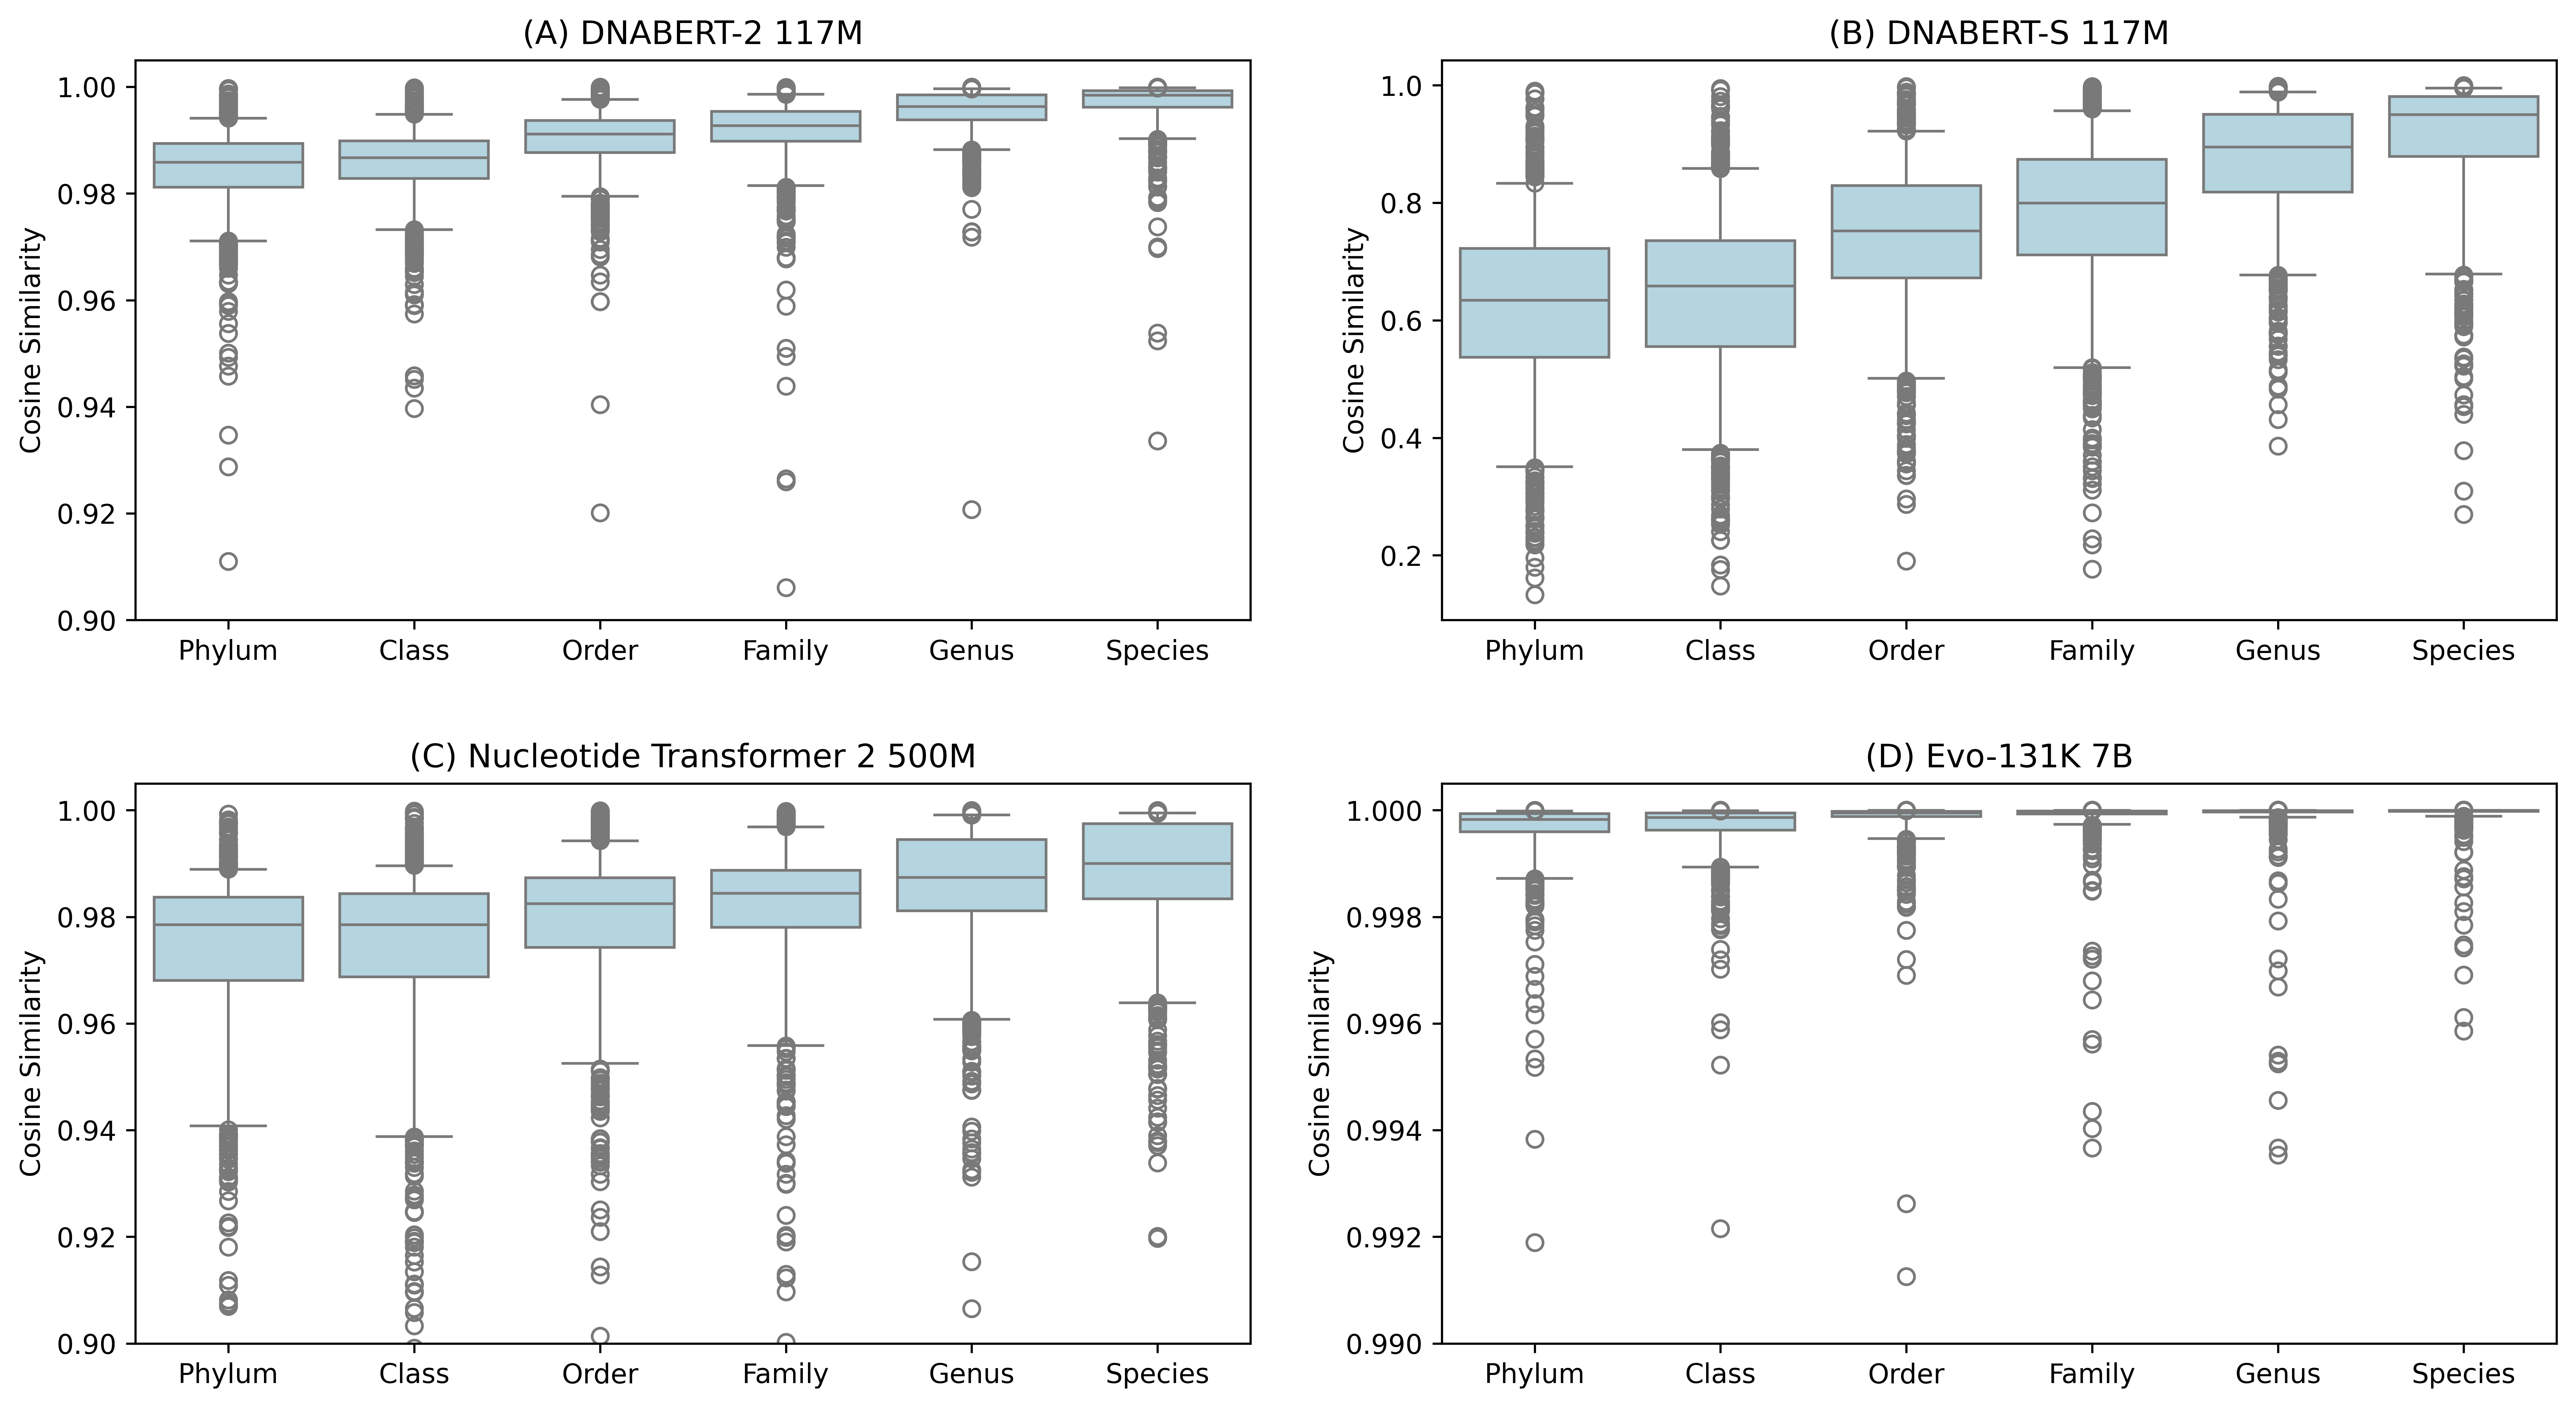

In [12]:
# Set up figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=600)
fig.tight_layout(pad=4.0)

# Flatten axes for easy iteration
axes = axes.flatten()

# DataFrames and titles
#dfs = [df1, df2, df3, df4]
titles = ['(A) DNABERT-2 117M', '(B) DNABERT-S 117M', '(C) Nucleotide Transformer 2 500M', '(D) Evo-131K 7B']
ranks = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

# Plot each boxplot
for ax, df_model, title in zip(axes, dfs.values(), titles):
    sns.boxplot(data=df_model, x='Level', y='Cosine Similarity', ax=ax, whis=(5, 95), color='lightblue')

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity')

    if title.startswith('(A)'):
        ax.set_ylim(0.9, 1.005)

    if title.startswith('(C)'):
        ax.set_ylim(0.9, 1.005)

    if title.startswith('(D)'):
        ax.set_ylim(0.99, 1.0005)
plt.show()

plt.show()

In [13]:
for df_model in dfs.values():
    means = df_model.groupby('Level')['Cosine Similarity'].mean()
    print(means)

Level
Class      0.985382
Family     0.991224
Genus      0.995443
Order      0.989859
Phylum     0.984255
Species    0.996923
Name: Cosine Similarity, dtype: float32
Level
Class      0.642355
Family     0.777930
Genus      0.870750
Order      0.740409
Phylum     0.621619
Species    0.910452
Name: Cosine Similarity, dtype: float32
Level
Class      0.973625
Family     0.980826
Genus      0.985231
Order      0.978818
Phylum     0.973055
Species    0.987667
Name: Cosine Similarity, dtype: float32
Level
Class      0.999671
Family     0.999865
Genus      0.999916
Order      0.999852
Phylum     0.999607
Species    0.999926
Name: Cosine Similarity, dtype: float32
